## Part 1

When $p$-norm in 2D with $p = 0.5$ is limitied under the conditions $|x|,|y| \geq 0$, the equation $(|x|^{0.5} + |y|^{0.5})^2 = 1$ boils down to :

$$ y = f(x) = 1 + x - 2\sqrt{x} $$

Domain and also the range of the function are $[0,1]$. Therefore :

$$ E[f(x)] = E[y] = <f(x)>_{x \mbox{~} U(0,1)} = \mbox{ Area under $f(x)$}$$

$$ <f(x)>_{x \mbox{~} U(0,1)} = \int dx * f(x) * U(x,0,1) $$

$$ <f(x)>_{x \mbox{~} U(0,1)} = \int dx * f(x) * \frac{U(x,0,1)}{q(x)} * q(x)$$

$$ <f(x)>_{x \mbox{~} U(0,1)} = < f(x)* w(x) >_{q(x)} = \int dx * f(x) * w(x) * q(x)$$

$$ < f(x)* w(x) >_{q(x)} \approx \frac{1}{N} \sum^N_{i=1} f(x^i)* w(x^i) \mbox{ where $x^i$ ~ $q$}$$


We choose $q(x) = -2x + 2$ provided $0\leq x \leq 1$ and we sample from this distribution using inverse method.




Area :  [ 0.66553948]
Variance :  0.0109709890757
Effective sample size :  989.148067359


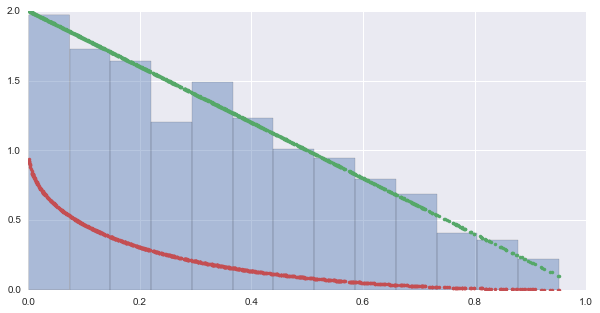

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

N = 1000

x = ((np.random.rand(N,1) * -1 + 1)**0.5 * -1) + 1 # inverse
u_x = np.ones([N,1]) # uniform distribution
q_x = -2 * x + 2 # proposal distribution, green curve
w_x = u_x / q_x # weight function
f_x = 1 + x - 2 * x ** 0.5 # target function

expected = sum(f_x * w_x)/ N
area = expected * 4
print 'Area : ', area

variance = np.var(f_x * w_x)
print 'Variance : ', variance

ess_n = N / (1 + variance)
print 'Effective sample size : ', ess_n

plt.figure(figsize=(10, 5))
axes = plt.gca()
axes.set_xlim([0,1])
histogram = sns.distplot(x,kde=False,norm_hist=True)
plt.plot(x,q_x,'.')
plt.plot(x,f_x,'.')


## Part 2

### (a) Transition Matrix

In [36]:
A = np.array([[0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
              [   0, 0.25,    0,    0, 0.25,    0],
              [   0,    0,    0, 0.50,    0,    0],
              [0.25, 0.25, 0.50,    0, 0.25, 0.25],
              [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
              [0.25,    0,    0,    0,    0, 0.25]]);

### (b) Stationary Distribution

See below that stationary distribution is not uniform.

In [41]:
e_values, e_vectors = np.linalg.eig(A)
lambda_one_index = np.argmax(np.isclose(e_values,1.0))
lambda_one_vector = e_vectors[:,lambda_one_index] 
lambda_one_vector /= sum(lambda_one_vector)
pi = lambda_one_vector
print 'Stationary distribution : ', pi # i.e. stationary distribution

Stationary distribution :  [ 0.25        0.08333333  0.11111111  0.22222222  0.25        0.08333333]


### (c) Detailed Balance

See below that this markov chain does not satisfy *detailed balance condition*

In [45]:
# lambda_one_vector --> stationary distribution
x = np.dot(A, np.diag(pi))
print x # not symmetric --> does not hold detailed balance condition
print '\n Holds detailed balance condition? ',np.isclose(x, x.T).all()

[[ 0.0625      0.02083333  0.02777778  0.05555556  0.0625      0.02083333]
 [ 0.          0.02083333  0.          0.          0.0625      0.        ]
 [ 0.          0.          0.          0.11111111  0.          0.        ]
 [ 0.0625      0.02083333  0.05555556  0.          0.0625      0.02083333]
 [ 0.0625      0.02083333  0.02777778  0.05555556  0.0625      0.02083333]
 [ 0.0625      0.          0.          0.          0.          0.02083333]]

 Holds detailed balance condition?  False


### (d) Find  $T_{mix}$

In [48]:
epsilon = 10 ** -8
pi_0 = [1.0,0,0,0,0,0]
pi_temp = np.dot(A,pi_0)
t_mix = 1
while np.linalg.norm(pi - pi_temp) > epsilon :
    pi_temp = np.dot(A,pi_temp)
    t_mix += 1
print 'T_mix : ', t_mix

T_mix :  24


### (e) Intermediary powers  of $A$

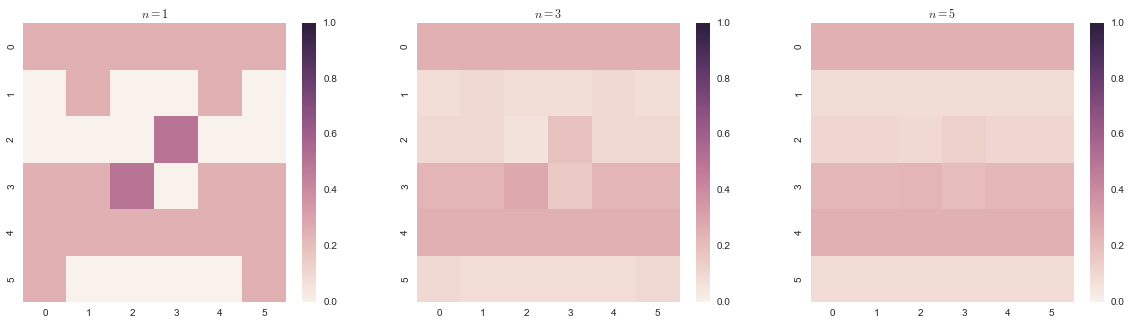

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i, n in enumerate([1, 3, 5]):
    sns.heatmap(np.linalg.matrix_power(A, n), vmin = 0, vmax = 1, ax = ax[i])
    ax[i].set_title("$n = %d$" % n)
plt.show()

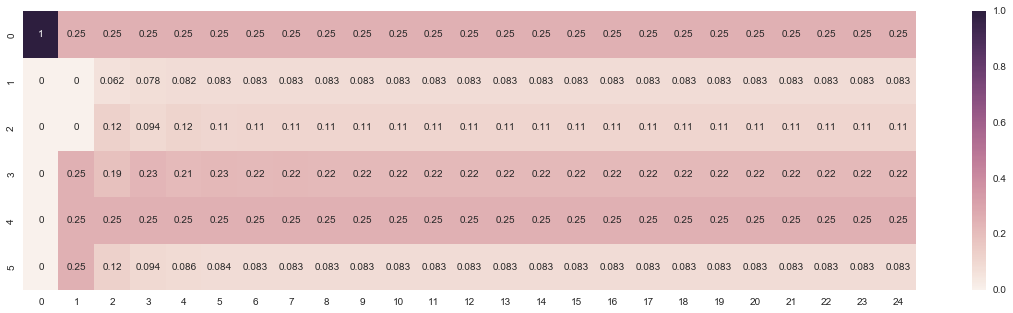

In [53]:
chain_length = 25
samples = np.zeros([6, chain_length])
samples[:,0] = [1,0,0,0,0,0]

for i in range(1, chain_length):
    samples[:,i] = np.dot(A,samples[:,i-1])


plt.figure(figsize=(20, 5))
sns.heatmap(samples,annot=True,)
plt.show()


### (f) Multiple Run Independent Samples

<Container object of 6 artists>

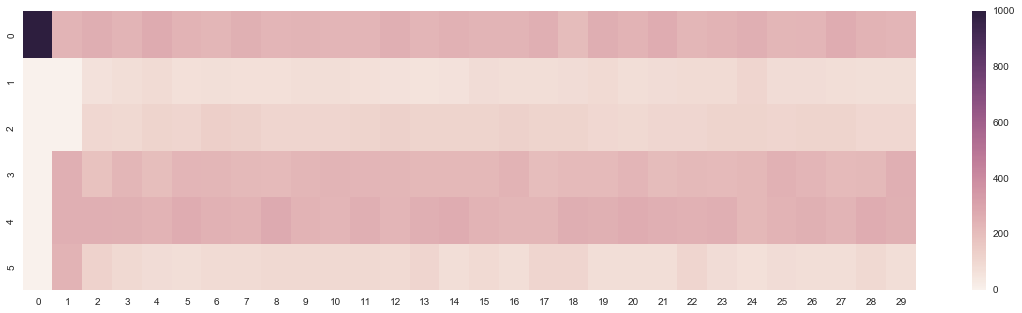

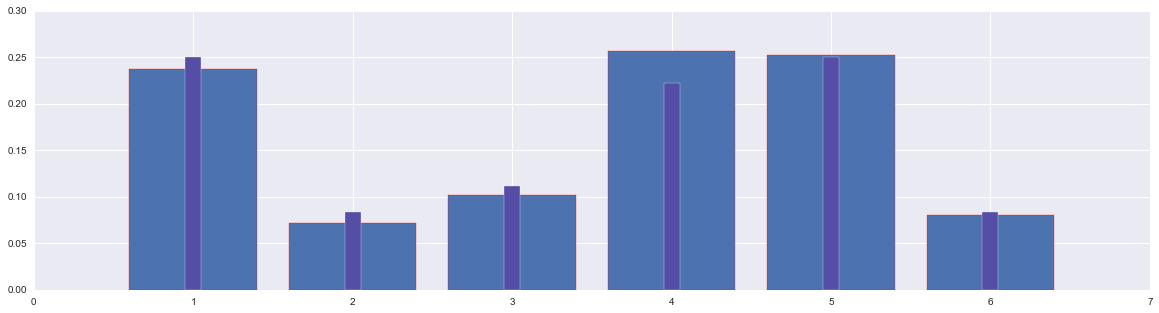

In [91]:
def sample(probabilities):
    bins = np.add.accumulate(probabilities)
    return np.argmax((np.random.rand() < bins))

def runChain(A,X_0,step):    
    sequence = np.zeros([step,1]).astype(int)
    sequence[0] = X_0
    for i in range(1,step):
        X = sequence[i-1]
        probs = A[:,X-1]
        sequence[i] = sample(probs) + 1
    return sequence.T
        
    
T_mix = 30
N = 1000
outcomes = np.zeros([N,T_mix]).astype(int)

for i in range(0,N):
    outcomes[i,:] = runChain(A,1,T_mix)

frequencies = np.zeros([6,T_mix]).astype(int)

for i in range(0,T_mix):
    b = np.bincount(outcomes[:,i])[1:]
    b = np.append(b,[0]*(6-len(b)))
    frequencies[:,i] = b
    
last_step_fq = frequencies[:,-1]

plt.figure(figsize=(20, 5))
sns.heatmap(frequencies,annot=False)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1,7), last_step_fq.astype(float)/sum(last_step_fq) ,edgecolor='red', align='center')
plt.bar(np.arange(1,7),pi, color='#554EA6', edgecolor='white', align='center', width=0.1)

### (g) One Run Steady-state Samples

<Container object of 6 artists>

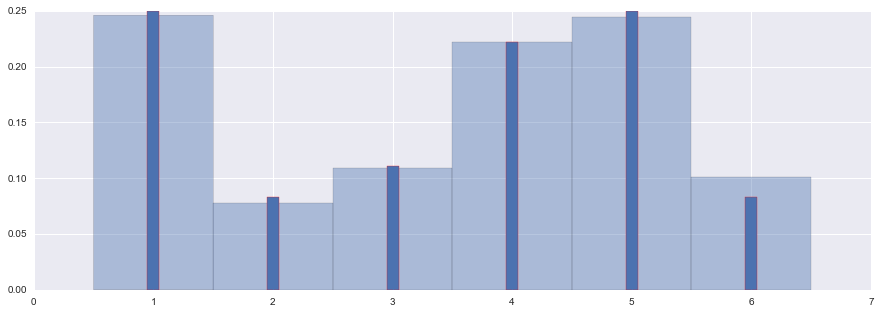

In [52]:
N = 1000
T_mix = 25
steady_samples = runChain(A,1,N+t_mix)[0,24:]
plt.figure(figsize=(15, 5))
sns.distplot(steady_samples, kde=False, rug=True,norm_hist=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]); # empiric results
plt.bar(np.arange(1,len(pi)+1), pi, edgecolor='red', width=0.1, align='center') # analytic results